In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [7]:
# The Fish Data Set
# See example 2 from https://stats.idre.ucla.edu/r/dae/zip/ 
#"nofish","livebait","camper","persons","child","xb","zg","count"
import os
from urllib.request import urlretrieve
if not os.path.isfile('fishing.npz'):
    print("Downloading")
    urlretrieve('http://www-home.htwg-konstanz.de/~oduerr/data/fishing.npz',filename = 'fishing.npz')
d = np.load('fishing.npz')
Xt = d['Xt'] #"livebait","camper","persons","child"
Xte = d['Xte']
yt = d['yt']
yte = d['yte']
pd.DataFrame(Xt[0:2])

,0,1,2,3
0,1.0,0.0,4.0,0.0
1,1.0,1.0,2.0,0.0


In [8]:
########### 1a Linear Regression by Hand #############

# insert intercept
intercept_column = np.ones((Xt.shape[0], 1), dtype=np.float64)
Xt_intercept = np.hstack((intercept_column, Xt))
print("Xt with intercept:")
print("Shape: ", Xt_intercept.shape)
print(Xt_intercept[0:2])

XTX = np.matmul(Xt_intercept.T,Xt_intercept)
XTXI = np.linalg.inv(XTX)
XTXIXT = np.matmul(XTXI, Xt_intercept.T)
w = np.matmul(XTXIXT,yt)

# Show the found weights
print("\nSolution of regression by hand: ")
print(w)

Xt with intercept:
Shape:  (200, 5)
[[1. 1. 0. 4. 0.]
 [1. 1. 1. 2. 0.]]

Solution of regression by hand: 
[-8.49222821  2.4822138   2.95430727  4.64953914 -5.47160051]


In [9]:
########### 1b Linear Regression with scikit #############

from sklearn.linear_model import LinearRegression
Xa = np.asarray(Xt_intercept)
ya = np.asarray(yt)
model_skl = LinearRegression(fit_intercept=False) #We have an extended X
model_skl.fit(Xa,ya)
print("Solution of regression by hand: ")
print(model_skl.coef_)

Solution of regression by hand: 
[-8.49222821  2.4822138   2.95430727  4.64953914 -5.47160051]


In [10]:
########### 1c RMSE and NLL #############

intercept_column = np.ones((Xte.shape[0], 1), dtype=np.float64)
Xte_intercept = np.hstack((intercept_column, Xte))
print("Xte with intercept:")
print("Shape: ", Xte_intercept.shape)
print(Xte_intercept[0:2])

yte_pred = np.matmul(Xte_intercept, w)

# RMSE
MSE = np.mean((yte_pred - yte)**2)
RMSE = np.sqrt(MSE)
print("\nRMSE: ", RMSE)

# Varianz
residuals = yte_pred - yte
yte_pred_var = np.var(residuals)
print("Variance: ", yte_pred_var)

# NLL
NLL = 0.5 * np.log(2 * np.pi * yte_pred_var) + 0.5 * np.mean((yte_pred - yte)**2) / yte_pred_var
print("NLL 1: ", NLL)
NLL = np.mean(yte_pred)
print("NLL 2: ", NLL)

Xte with intercept:
Shape:  (50, 5)
[[1. 0. 0. 3. 0.]
 [1. 1. 0. 3. 1.]]

RMSE:  8.588126386734231
Variance:  73.48030359919811
NLL 1:  3.5693226381682024
NLL 2:  3.584986890619827


Mean True:  3.06
Mean Pred:  3.584986890619827
Variance True:  102.416405
Variance Pred:  73.48030359919811


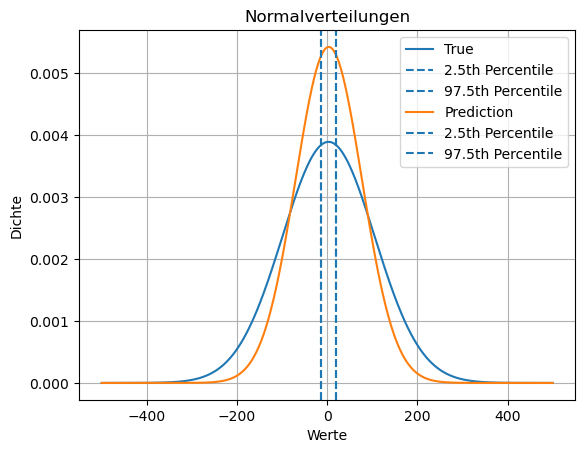

In [11]:
########### 1d Gaussian Plot #############
from scipy.stats import norm

# Compute mean of pred and real
mean_true = np.mean(yte)
mean_pred = np.mean(yte_pred)
print("Mean True: ", mean_true)
print("Mean Pred: ", mean_pred)

var_true = np.var(yte)
var_pred = yte_pred_var
print("Variance True: ", var_true)
print("Variance Pred: ", var_pred)

x = np.linspace(-500, 500, 1000)
pdf_true = norm.pdf(x, mean_true, var_true)
pdf_pred = norm.pdf(x, mean_pred, var_pred)

percentile025_true = mean_true - 1.96 * RMSE
percentile975_true = mean_true + 1.96 * RMSE
percentile025_pred = mean_pred - 1.96 * RMSE
percentile975_pred = mean_pred + 1.96 * RMSE

# plotting
plt.plot(x, pdf_true, label='True')
plt.axvline(x=percentile025_true, linestyle='--', label='2.5th Percentile')
plt.axvline(x=percentile975_true, linestyle='--', label='97.5th Percentile')

# plot predicted fish
plt.plot(x, pdf_pred, label='Prediction')
plt.axvline(x=percentile025_pred, linestyle='--', label='2.5th Percentile')
plt.axvline(x=percentile975_pred, linestyle='--', label='97.5th Percentile')

plt.title('Normalverteilungen')
plt.xlabel('Werte')
plt.ylabel('Dichte')
plt.grid(True)
plt.legend()
plt.show()

In [17]:
########### 1e Gradient Descent #############
import math

def poisson_nll(beta, X):
    mu = np.exp(np.matmul(X, beta))
    k = mu.shape[0]
    NLL = -mu + k * np.log(mu) -np.log(math.factorial(k))
    return NLL




In [20]:
import tensorflow as tf
#import tensorflow_probability as tfp

epochs = 5000
lr = 0.001
Xs = tf.Variable(np.asmatrix(Xt_intercept,dtype='float32'))
ws = tf.Variable((1.,1.,1.,1.,1.))
print(Xs.shape)
print(ws.shape)

for i in range(epochs):
    with tf.GradientTape() as tape: #Mechanism to store gradients
        # y_hat = tf.matmul(Xs,ws)
        # loss = tf.reduce_logsumexp((yt - y_hat)**2) #MSE
        loss = poisson_nll(ws, Xs)
        if i % 500 == 0:
            print(i, "  ",ws.numpy().T,'  ',loss.numpy())
        grads = tape.gradient(loss, ws) #gradient wrt w
        ws = tf.Variable(ws - lr * grads)
print("grads: ", grads)

yte_pred = np.matmul(Xte_intercept, ws)

# Calculate Root Mean Square Error (RMSE) on the test set
RMSE = np.sqrt(np.mean((yte_pred - yte) ** 2))

# Calculate the NLL on the test set
NLL = poisson_nll(ws, Xte_intercept)

print(f"With Gradient Descent and Poisson:\nRMSE:\t\t{RMSE}\nNLL:\t\t{NLL}\n")

(200, 5)
(5,)


TypeError: loop of ufunc does not support argument 0 of type int which has no callable log method

Text(0.5, 1.0, 'Poisson Wahrscheinlichtkeitsfunktion')

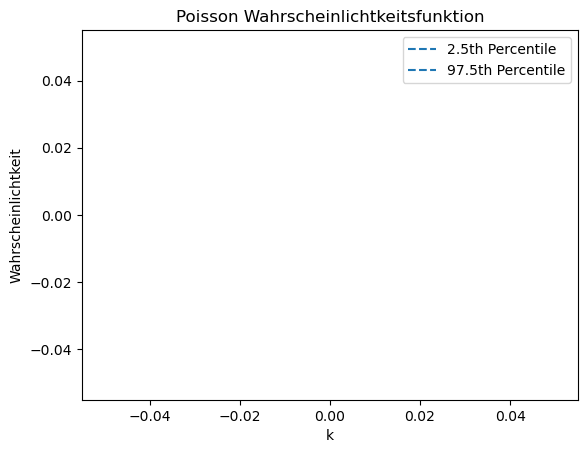

In [16]:
########### 1f Plot with Poison CPD #############
from scipy.stats import poisson

x = np.arange(0, 20)
pmf = poisson.pmf(x, mu=NLL)
percentiles = poisson.ppf([0.025, 0.975], mu=NLL)

# Plotting
plt.plot(x, pmf, marker='o', linestyle='-')
plt.axvline(x=percentiles[0], linestyle='--', label='2.5th Percentile')
plt.axvline(x=percentiles[1], linestyle='--', label='97.5th Percentile')
plt.legend()
plt.xlabel('k')
plt.ylabel('Wahrscheinlichtkeit')
plt.title('Poisson Wahrscheinlichtkeitsfunktion')